## Model description

https://easychair.org/publications/paper/1ff2

Three-dimensional ODE of the plant without discrete-time PI-controller (HAY QUE ACTUALIZAR ESTAS ECUACIONES):

$$
   \left\{ \begin{array}{lcl}
   \dot{I} & = & \frac{1}{L}\cdot\left( \left(K_P\cdot\left(x_0-x\right)+K_I\cdot x_c \right) - I\cdot\left(R - \frac{K^2}{d_{rot}}\right)\right) \\
   \dot{x} & = & \frac{K}{i\cdot d_{rot}}\cdot I \\
   \dot{x_c} & = & x_0-x \end{array}
   \right.
$$

In [1]:
using TaylorIntegration, MathematicalSystems, HybridSystems, SparseArrays
using Revise, Reachability
include("helper.jl")

┌ Info: Recompiling stale cache file /home/mforets/.julia/compiled/v1.2/Reachability/CHV4V.ji for Reachability [774a0091-654f-5c65-bbdc-ad5b67b45832]
└ @ Base loading.jl:1240


times (generic function with 2 methods)

In [2]:
function EMBrake_hibrid()
    # the state variables are:
    # [I, x, T, xe, xc]

    # model's constants
    L       = 1.e-3;
    KP      = 10000.;
    KI      = 1000.;
    R       = 0.3;
    K       = 0.02;
    drot    = 0.1;
    i       = 113.1167;
    Tsample = 1.E-4;
    
    EMbrake = LightAutomaton(1)

    # Braking mode: x' =  Ax + b
    A = [-(R+K^2/drot)/L 0   0   KP/L  KI/L; 
           K/i/drot      0   0   0      0;
           0             0   0   0      0;
           0             0   0   0      0;
           0             0   0   0      0]
    A = sparse(A)
    b = [0, 0, 1.0, 0, 0]
    b = sparse(b)
    X = HalfSpace([0.0, 0.0, 1.0, 0.0, 0.0], Tsample) # invariant
    brake = ConstrainedAffineContinuousSystem(A, b, X)
    modes = [brake]

    # transition (self-loop)
    add_transition!(EMbrake, 1, 1, 1)
    x0 = 0.05
    A = sparse([1, 2, 4, 5, 5], [1, 2, 2, 2, 5], [1., 1., -1., -Tsample, 1.], 5, 5);
    b = sparsevec([4, 5], [x0, Tsample*x0], 5)
    guard = HalfSpace([0.0, 0.0, -1.0, 0.0, 0.0], -Tsample); # T >= Tsample
    resetmaps = [ConstrainedAffineMap(A, b, guard)]
    switchings = [AutonomousSwitching()]

    H = HybridSystem(EMbrake, modes, resetmaps, switchings)
end

EMBrake_hibrid (generic function with 1 method)

### Reachability settings

In [3]:
I₀  = Singleton([0.0]); #Interval(0., 0.);
x₀  = Singleton([0.0]); #Interval(0., 0.);
T₀  = Singleton([0.0]); #Interval(0., 0.);
xe₀ = Singleton([0.0]); #Interval(0., 0.);
xc₀ = Singleton([0.0]); #Interval(0., 0.);

X₀ = I₀ × x₀ × T₀ × xe₀ × xc₀;
#X₀ = X₀ ⊕ BallInf(zeros(dim(X₀)), 0.0001);

### Results

In [4]:
H = EMBrake_hibrid()
P = InitialValueProblem(H, [(1, X₀)]);

In [49]:
alg = BFFPSV18(:δ=>1e-4)
# opD = LazyDiscretePost(:check_invariant_intersection => true)
sol = solve(P, Options(:T=>0.4, :verbosity=>0, :max_jumps=>100), alg);

In [25]:
using Plots

In [51]:
I_vs_t = []
tiempos = []

for F in sol.flowpipes
    XF = project(F, [1])
    TF = times(F)
    append!(tiempos, TF)
    append!(I_vs_t, [TF[i] × XF[i] for i in eachindex(TF)])
end

In [50]:
43000 / 60 / 60

11.944444444444445

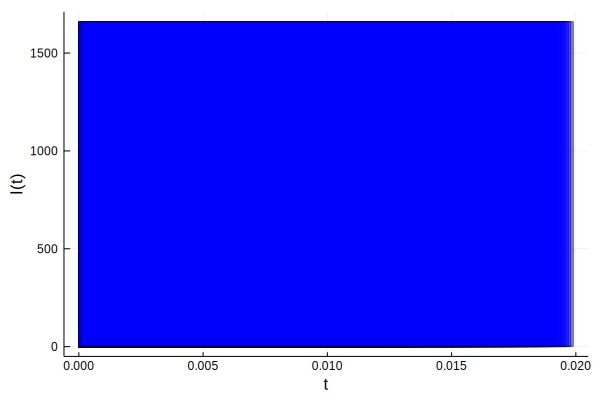

In [52]:
plot([x for x in I_vs_t], xlab="t", ylab="I(t)", color=:blue)

# Computing before the first jump

In [147]:
H = EMBrake_hibrid()
S = H.modes[1]
S = AffineContinuousSystem(S.A, S.c) # sacar los campos matriz y desplazamiento, ignorando el constraint set X
Pc(X₀) = InitialValueProblem(S, X₀); # problema continuo para una condicion inicial dada

In [224]:
alg = BFFPSV18(:δ=>1e-5)
@time sol = solve(Pc(X₀), Options(:T =>0.02, :verbosity=>0), op=alg);
F = sol.flowpipes[1];

  0.118324 seconds (940.37 k allocations: 48.156 MiB, 29.90% gc time)


In [225]:
X1_ = F.reachsets[1].rs.X

CartesianProductArray{Float64,LazySet{Float64}}(LazySet{Float64}[Interval{Float64,IntervalArithmetic.Interval{Float64}}([-0, 0]), Interval{Float64,IntervalArithmetic.Interval{Float64}}([-0, 0]), Interval{Float64,IntervalArithmetic.Interval{Float64}}([-0, 1.00001e-05]), Interval{Float64,IntervalArithmetic.Interval{Float64}}([-0, 0]), Interval{Float64,IntervalArithmetic.Interval{Float64}}([-0, 0])])

In [226]:
overapproximate(X1_, Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.0, 0.0, 5.0e-6, 0.0, 0.0], [0.0, 0.0, 5.0e-6, 0.0, 0.0])

Para $t \in [0, T_s]$, todas las variables valen $0$.

Cuando $t = T_s$ se aplica el primer reset.

Nueva condicion inicial para $t \in (T_s, 2T_s]$:

In [198]:
m = H.resetmaps[1]
Ar = m.A
br = m.b;
salto(x) = Ar * x + br

salto (generic function with 1 method)

In [200]:
X1 = salto(X₀);

In [125]:
using DifferentialEquations

In [179]:
A = P.s.A
b = P.s.c
x0 = zeros(5)
x1 = Ar * x0 + br
tspan = (0.0, 0.1)
f(x, p, t) = A*x + b
prob = ODEProblem(f, x1, tspan)

ODEProblem with uType SparseVector{Float64,Int64} and tType Float64. In-place: false
timespan: (0.0, 0.1)
u0:   [4]  =  0.05
  [5]  =  5.0e-6

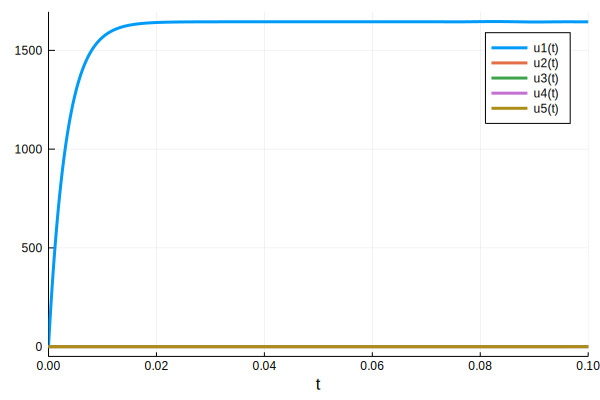

In [180]:
sol = DifferentialEquations.solve(prob)
plot(sol)

In [169]:
alg = BFFPSV18(:δ=>1e-5)
@time sol = solve(Pc(X1), Options(:T =>0.02, :verbosity=>1), op=alg);
F = sol.flowpipes[1];

[info] Reachable States Computation...
[info] Time discretization...
[info] elapsed time: 1.874e+00 seconds
[info] - Decomposing X0
[info] elapsed time: 1.080e-01 seconds
[info] - Computing successors
[info] elapsed time: 1.150e-01 seconds
[info] - Total
[info] elapsed time: 2.394e+00 seconds
  7.282997 seconds (13.40 M allocations: 707.816 MiB, 6.51% gc time)


In [170]:
length(F.reachsets)

2000

In [171]:
overapproximate(F.reachsets[10].rs.X, Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([46.822979034508904, 3.984567122077862e-6, 9.499999999999857e-5, 0.04999999999999832, 4.999999999999832e-6], [2.4325590551910494, 4.3667891032828025e-7, 4.999999999999844e-6, 9.020562075079397e-17, 8.893845946170154e-21])

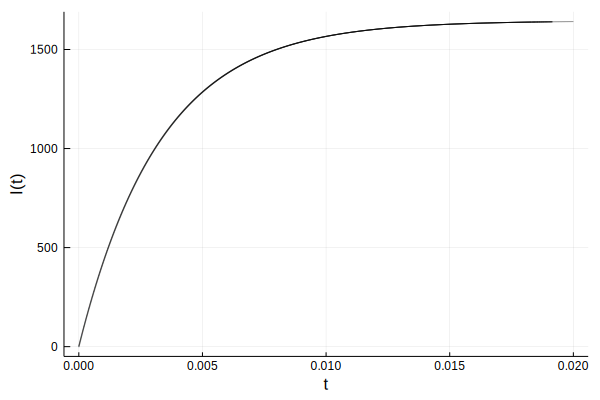

In [172]:
Xk_1 = project(F, [1])
tiempos = times(F)
I_vs_t = [tiempos[i] × Xk_1[i] for i in eachindex(tiempos)];
plot(I_vs_t, xlab="t", ylab="I(t)")

In [188]:
Tsample = 1e-4

0.0001

In [229]:
findfirst(x -> Tsample ∈ x, tiempos)

10

In [193]:
tiempos[10]

Interval{Float64,IntervalArithmetic.Interval{Float64}}([9e-05, 0.000100001])

In [195]:
# PENSAR SI ESTO FALTA? CH(exp(A*delta)*X0, X0) # ????

Todo lo que va en $t \in [T_s, 2T_s]$:

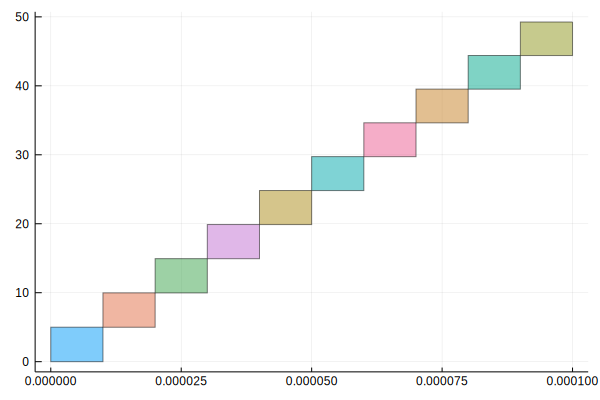

In [194]:
plot(I_vs_t[1:10])

In [210]:
X2 = salto(F.reachsets[9].rs.X)
overapproximate(X2, Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([87.57989769306258, 1.4150873860953666e-5, 0.0, 0.04998584912613905, 1.4998186455901226e-5], [4.74121566610453, 1.5938866148651714e-6, 0.0, 1.5938866148659803e-6, 2.0305655254636225e-10])

In [219]:
overapproximate(project(F.reachsets[9].rs.X, [3], LazySets.LinearMap), Interval)

Interval{Float64,IntervalArithmetic.Interval{Float64}}([7.99999e-05, 9e-05])

0.0001

In [203]:
alg = BFFPSV18(:δ=>1e-5)
@time sol = solve(Pc(X2), Options(:T =>0.02, :verbosity=>1), op=alg);
F = sol.flowpipes[1];

[info] Reachable States Computation...
[info] Time discretization...
[info] elapsed time: 2.704e-01 seconds
[info] - Decomposing X0
[info] elapsed time: 7.980e-02 seconds
[info] - Computing successors
[info] elapsed time: 1.091e-01 seconds
[info] - Total
[info] elapsed time: 7.374e-01 seconds
  1.227539 seconds (2.56 M allocations: 130.501 MiB, 8.74% gc time)


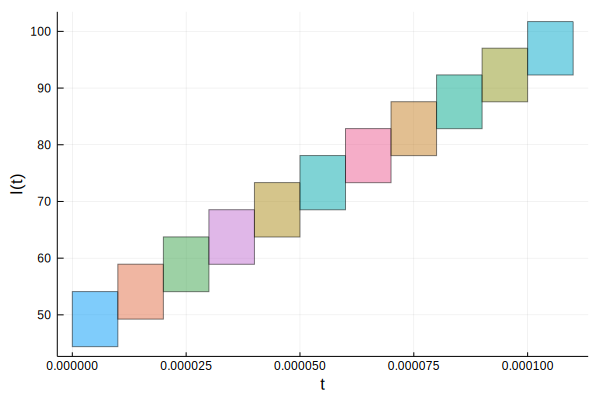

In [218]:
Xk_1 = project(F, [1])
tiempos = times(F)
I_vs_t = [tiempos[i] × Xk_1[i] for i in eachindex(tiempos)];
plot(I_vs_t[1:11], xlab="t", ylab="I(t)")

# Integrador hibrido a mano

In [249]:
function idx_salto(F, Tsample)
    # el primer i tal que el tiempo es >= Tsample
    return findfirst(x -> Tsample ∈ x, times(F)) 
end

function integrar_hibrid(Pc; alg=BFFPSV18(:δ=>1e-5), T=0.02, opts=Options(:T => T, :verbosity=>0),
                             X₀=Singleton(zeros(5)), Tsample=1e-4, max_jumps=2)

    sol_h = []
    X₀ᵢ = copy(X₀)

    for k in 1:max_jumps
        sol = solve(Pc(X₀ᵢ), opts, op=alg)
        F = sol.flowpipes[1]
        i = idx_salto(F, Tsample)
        push!(sol_h, F.reachsets[1:i])
        X₀ᵢ = salto(F.reachsets[i].rs.X)
    end
    return sol_h
end

integrar_hibrid (generic function with 1 method)

In [282]:
sol = integrar_hibrid(Pc, max_jumps=500);

In [283]:
I_vs_t = []
tiempos = []

import IntervalArithmetic
const IA = IntervalArithmetic

t_ultimo = 0.0
for soli in sol
    local tproj
    for Xi in soli
        Xproj = project(Xi.rs.X, [1], LazySets.LinearMap)
        tproj = IA.Interval(Xi.rs.t_start + t_ultimo, Xi.rs.t_end + t_ultimo)
        push!(tiempos, tproj)
        push!(I_vs_t, LazySets.Interval(tproj) × Xproj)
    end
    t_ultimo = IA.sup(tproj)
end

In [284]:
plot([x for x in I_vs_t])